In [0]:
from sklearn.preprocessing import LabelBinarizer as LB
from sklearn.preprocessing import normalize 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# --------------------
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.core import Reshape, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras import metrics
# --------------------
from pandas import DataFrame as df
# --------------------
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
# --------------------
import tarfile
import pickle
import random
import keras
import sys
import gc


Using TensorFlow backend.


In [0]:
!wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
!tar jxf RML2016.10b.tar.bz2

--2019-05-07 10:25:10--  http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
Resolving opendata.deepsig.io (opendata.deepsig.io)... 52.14.91.165
Connecting to opendata.deepsig.io (opendata.deepsig.io)|52.14.91.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245608913 (1.2G) [application/x-bzip2]
Saving to: ‘RML2016.10b.tar.bz2’

RML2016.10b.tar.bz2 100%[===================>]   1.16G  14.7MB/s    in 80s     

2019-05-07 10:26:30 (14.9 MB/s) - ‘RML2016.10b.tar.bz2’ saved [1245608913/1245608913]



In [0]:
file = open("RML2016.10b.dat",'rb')
Xd = pickle.load(file, encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = [] 
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()

## Create Features Space

In [0]:
features = {}

**Raw Time Feature**

In [0]:
features['raw']        = X[:,0], X[:,1]

**First derivative in time**

In [0]:
features['derivative'] = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))

**Integral in time**

In [0]:
features['integral']   = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))

**All Togetheer Feature Space**

In [0]:
def extract_features(*arguments):
    
    desired = ()            
    for arg in arguments:
        desired += features[arg]
    
    return np.stack(desired, axis = 1)

## Train and Test Data Split

** features Choice **

In [0]:
data = extract_features('raw')
labels = np.array(lbl)

In [0]:
in_shape = data[0].shape
out_shape = tuple([1]) + in_shape

** data shuffling & splitting **

In [0]:
np.random.seed(10)

n_examples = labels.shape[0]

r = np.random.choice(range(n_examples), n_examples, replace = False)

train_examples = r[:n_examples//2]
test_examples =  r[n_examples//2:]

In [0]:
X_train = data[train_examples]
X_test = data[test_examples]

y_train = LB().fit_transform(labels[train_examples][:,0])
y_test = LB().fit_transform(labels[test_examples][:,0])

snr_train = labels[train_examples][:,1].astype(int)
snr_test = labels[test_examples][:,1].astype(int)

## Model for Fully Connected Nueral Networks

In [0]:
model = Sequential()
model.add(Dense(128, activation ='relu', input_shape = in_shape))
model.add(Dense(256, activation ='relu'))
model.add(Dense(128, activation ='relu'))
model.add(Flatten())
model.add(Dense(10, activation ='softmax'))

In [0]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 2, 128)            16512     
_________________________________________________________________
dense_18 (Dense)             (None, 2, 256)            33024     
_________________________________________________________________
dense_19 (Dense)             (None, 2, 128)            32896     
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                2570      
Total params: 85,002
Trainable params: 85,002
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X_train, y_train, epochs = 100, validation_split = 0.05, batch_size = 2048, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])

Train on 570000 samples, validate on 30000 samples
Epoch 1/100
570000/570000 [==============================] - 3s 5us/step - loss: 1.9505 - acc: 0.2401 - val_loss: 1.7490 - val_acc: 0.3070
Epoch 2/100
570000/570000 [==============================] - 2s 4us/step - loss: 1.6754 - acc: 0.3297 - val_loss: 1.5935 - val_acc: 0.3523
Epoch 3/100
570000/570000 [==============================] - 2s 4us/step - loss: 1.5797 - acc: 0.3639 - val_loss: 1.5399 - val_acc: 0.3792
Epoch 4/100
570000/570000 [==============================] - 2s 4us/step - loss: 1.5408 - acc: 0.3788 - val_loss: 1.5182 - val_acc: 0.3781
Epoch 5/100
570000/570000 [==============================] - 2s 4us/step - loss: 1.5179 - acc: 0.3855 - val_loss: 1.4933 - val_acc: 0.3894
Epoch 6/100
570000/570000 [==============================] - 2s 4us/step - loss: 1.5012 - acc: 0.3909 - val_loss: 1.4814 - val_acc: 0.4014
Epoch 7/100
570000/570000 [==============================] - 2s 4us/step - loss: 1.4892 - acc: 0.3951 - val_loss: 1

In [0]:
model.save('ann.h5')

## "AbRo" Model for Convolution Connected Neural Networks

In [0]:
dr = 0.5
model = Sequential()
model.add(Reshape(out_shape, input_shape = in_shape))
model.add(ZeroPadding2D((0, 2), data_format = 'channels_first'))
model.add(Conv2D(256, (1, 3), padding = 'valid', activation = "relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2), data_format = 'channels_first'))
model.add(Conv2D(80, (2, 3), activation="relu", name="conv3", padding="valid", kernel_initializer="glorot_uniform", data_format="channels_first"))
model.add(Dropout(dr))
model.add(Flatten())   
model.add(Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal"))
model.add(Dropout(dr))
model.add(Dense(10, name="dense3", kernel_initializer="he_normal", activation = 'softmax'))
model.add(Reshape([len(mods)]))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_66 (Reshape)         (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_76 (ZeroPaddi (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_39 (Dropout)         (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_77 (ZeroPaddi (None, 256, 2, 134)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 80, 1, 132)        122960    
_________________________________________________________________
dropout_40 (Dropout)         (None, 80, 1, 132)        0         
__________

In [0]:
model.fit(X_train, y_train, epochs = 80, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])

Train on 570000 samples, validate on 30000 samples
Epoch 1/80
570000/570000 [==============================] - 58s 101us/step - loss: 1.1971 - acc: 0.4956 - val_loss: 1.1119 - val_acc: 0.5397
Epoch 2/80
570000/570000 [==============================] - 58s 101us/step - loss: 1.1916 - acc: 0.4976 - val_loss: 1.1040 - val_acc: 0.5362
Epoch 3/80
570000/570000 [==============================] - 58s 101us/step - loss: 1.1895 - acc: 0.4987 - val_loss: 1.0946 - val_acc: 0.5404
Epoch 4/80
570000/570000 [==============================] - 58s 101us/step - loss: 1.1869 - acc: 0.5001 - val_loss: 1.0999 - val_acc: 0.5363
Epoch 5/80
570000/570000 [==============================] - 58s 101us/step - loss: 1.1820 - acc: 0.5034 - val_loss: 1.0884 - val_acc: 0.5440
Epoch 6/80
570000/570000 [==============================] - 58s 101us/step - loss: 1.1774 - acc: 0.5060 - val_loss: 1.0881 - val_acc: 0.5441
Epoch 7/80
570000/570000 [==============================] - 58s 101us/step - loss: 1.1740 - acc: 0.5069

In [0]:
model.save("cnn.h5")

## Evaluation

In [0]:
def plot_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)

In [0]:
def print_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
  y_true, y_pred = np.argmax(y_true, axis = 1), np.argmax(y_pred, axis = 1)
  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title = 'Confusion Matrix',
         ylabel = 'True label',
         xlabel = 'Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

** Fully Connected Neural Network Evaluation **

In [0]:
ann_model = keras.models.load_model('ann.h5')

In [0]:
y_pred_ann = ann_model.predict(X_test)

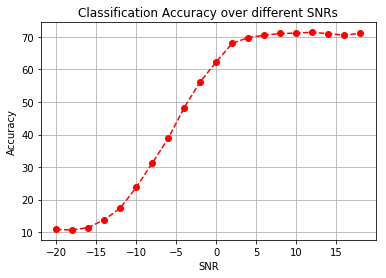

In [0]:
plot_results(y_pred_ann, y_test, snr_test)

In [0]:
print_results(y_pred_ann, y_test, snr_test)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.85,10.7,11.41,13.79,17.34,23.75,31.16,38.81,48.29,56.21,62.31,68.04,69.79,70.51,71.06,71.15,71.44,70.98,70.56,71.11


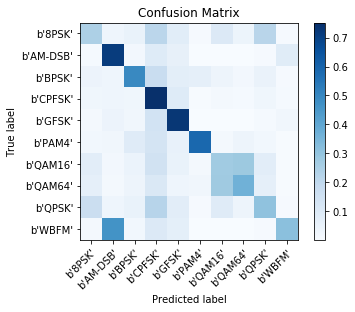

In [0]:
plot_confusion_matrix(y_test, y_pred_ann, mods)

** Convolutional Neural Network Evaluation **

In [0]:
cnn_model = keras.models.load_model('cnn.h5')

In [0]:
y_pred_cnn = model.predict(X_test)

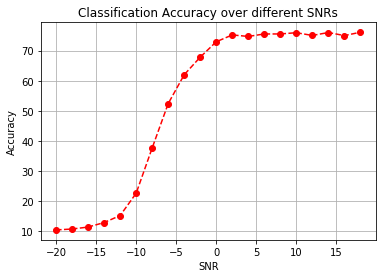

In [0]:
plot_results(y_pred_cnn, y_test, snr_test)

In [0]:
print_results(y_pred_cnn, y_test, snr_test)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.5,10.79,11.44,12.94,15.26,22.64,37.67,52.41,62.0,67.83,72.94,75.21,74.71,75.53,75.53,75.95,75.04,76.01,74.99,76.1


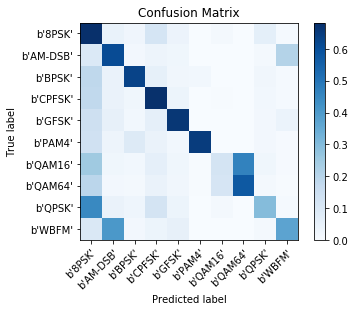

In [0]:
plot_confusion_matrix(y_test, y_pred_cnn, mods)

In [0]:
def train_once(size = 5000):
  dr = 0.5
  model = Sequential()
  model.add(Reshape(out_shape, input_shape = in_shape))
  model.add(ZeroPadding2D((0, 2), data_format = 'channels_first'))
  model.add(Conv2D(256, (1, 3), padding = 'valid', activation = "relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first"))
  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0,2), data_format = 'channels_first'))
  model.add(Conv2D(80, (2, 3), activation="relu", name="conv3", padding="valid", kernel_initializer="glorot_uniform", data_format="channels_first"))
  model.add(Dropout(dr))
  model.add(Flatten())   
  model.add(Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal"))
  model.add(Dropout(dr))
  model.add(Dense(10, name="dense3", kernel_initializer="he_normal", activation = 'softmax'))
  model.add(Reshape([len(mods)]))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
  #model.summary()
  model.fit(X_train[:size], y_train[:size], epochs = 100, batch_size = 1024, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])
  train_pred = model.evaluate(X_train[:size], y_train[:size])
  test_pred = model.evaluate(X_test, y_test)
  return traind_pred, test_pred
  

In [0]:
list(range(5000, 100000, 5000))

[5000,
 10000,
 15000,
 20000,
 25000,
 30000,
 35000,
 40000,
 45000,
 50000,
 55000,
 60000,
 65000,
 70000,
 75000,
 80000,
 85000,
 90000,
 95000]

In [0]:
train_scores, test_scores = [], []
rang = range(5000, 100000, 5000)
for i in rang:
  trn, tst = train_once(i)
  train_scores.append(trn)
  test_scores.append(tst)

plt.imshow(rang, train_scores, 'ro--', rang, test_scores, 'bo--')